# License Plate Detection using MSER Algorithm

This notebook demonstrates license plate detection using MSER (Maximally Stable Extremal Regions) algorithm with OpenCV. MSER is particularly effective for detecting text-like regions in images, making it suitable for license plate detection.

## 1. Import Required Libraries

Import OpenCV and NumPy libraries needed for image processing and MSER detection.

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

## 2. Load and Prepare Image

Load the sample image and convert it to grayscale for MSER processing. MSER works on single-channel images.

Image loaded successfully. Shape: (480, 640, 3)


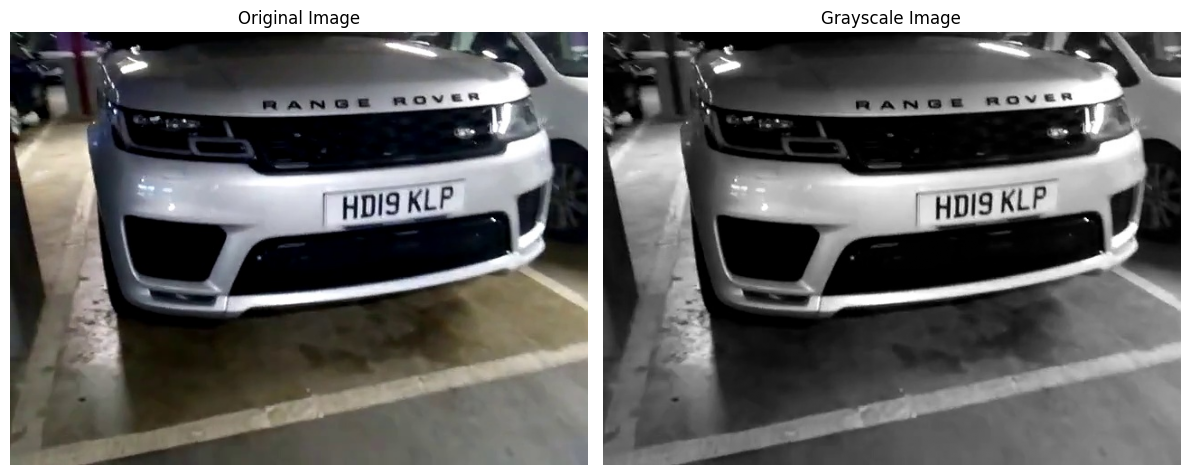

In [15]:
# Load image
image = cv2.imread("./sample_images/4.jpg")
if image is None:
    print("Error: Could not load image. Please check the file path.")
else:
    print(f"Image loaded successfully. Shape: {image.shape}")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Convert BGR to RGB for proper display in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(image_rgb)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(gray, cmap='gray')
ax2.set_title('Grayscale Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

## 2.1 Preprocessing with Gaussian Blur (Optional)

Gaussian blur can help improve MSER detection by:
- Reducing noise that creates false regions
- Making genuine text regions more stable
- Smoothing minor intensity variations

Let's compare results with and without Gaussian blur.

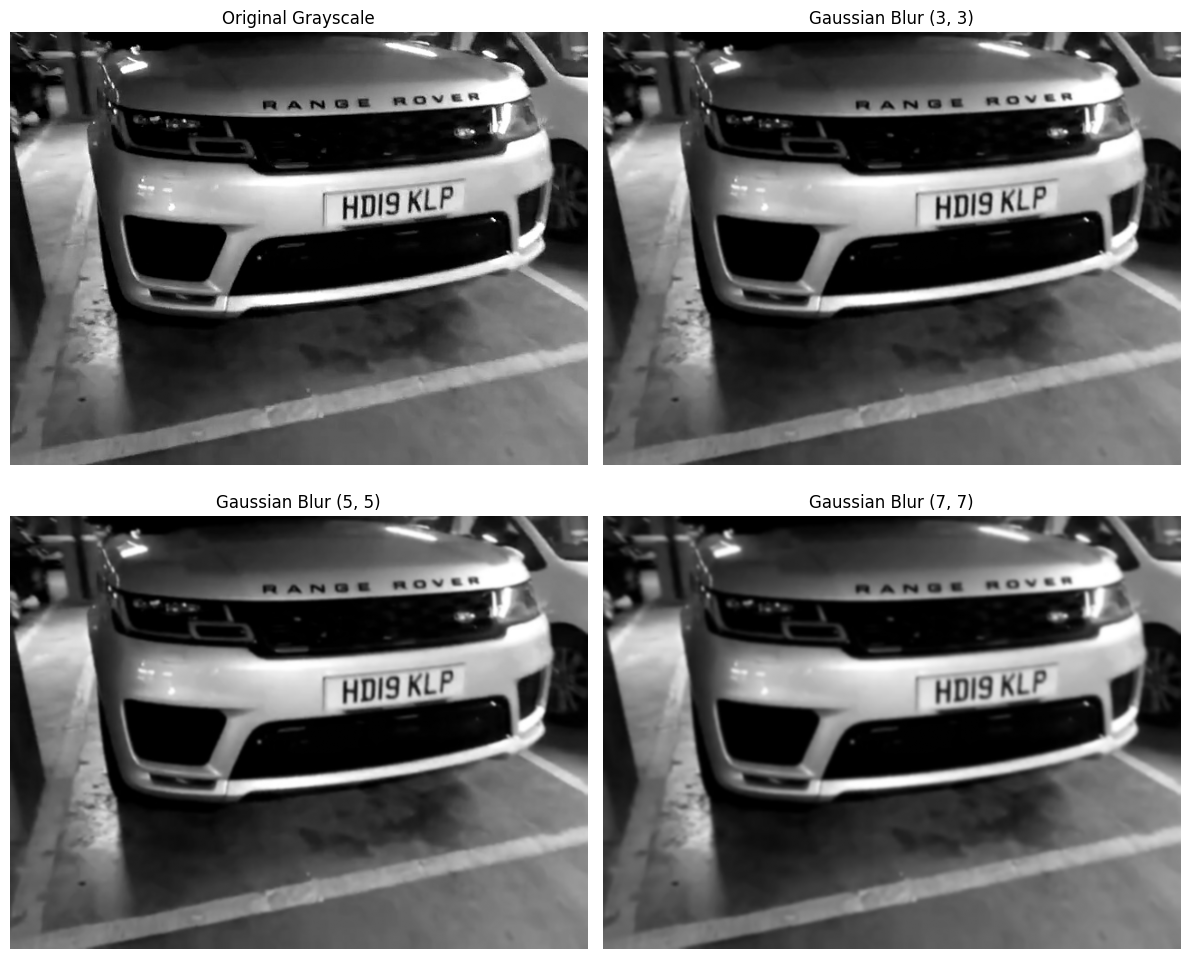

Gaussian blur preprocessing completed
Kernel sizes tested: ['(3, 3)', '(5, 5)', '(7, 7)']


In [16]:
# Apply Gaussian blur with different kernel sizes
blur_kernel_sizes = [(3, 3), (5, 5), (7, 7)]
blurred_images = {}

for kernel_size in blur_kernel_sizes:
    blurred = cv2.GaussianBlur(gray, kernel_size, 0)
    blurred_images[kernel_size] = blurred

# Display original vs blurred versions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Original grayscale
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[0].axis('off')

# Different blur levels
for i, (kernel_size, blurred) in enumerate(blurred_images.items()):
    axes[i+1].imshow(blurred, cmap='gray')
    axes[i+1].set_title(f'Gaussian Blur {kernel_size}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print("Gaussian blur preprocessing completed")
print("Kernel sizes tested:", [str(k) for k in blur_kernel_sizes])

## 2.2 Compare MSER Detection with Blur Preprocessing

Let's compare how MSER performs on the original image versus blurred versions.

MSER Detection Results Comparison:
Original    :  675 total regions → 132 filtered
Blur (3, 3) :  660 total regions → 117 filtered
Blur (5, 5) :  617 total regions → 118 filtered
Blur (7, 7) :  565 total regions → 107 filtered


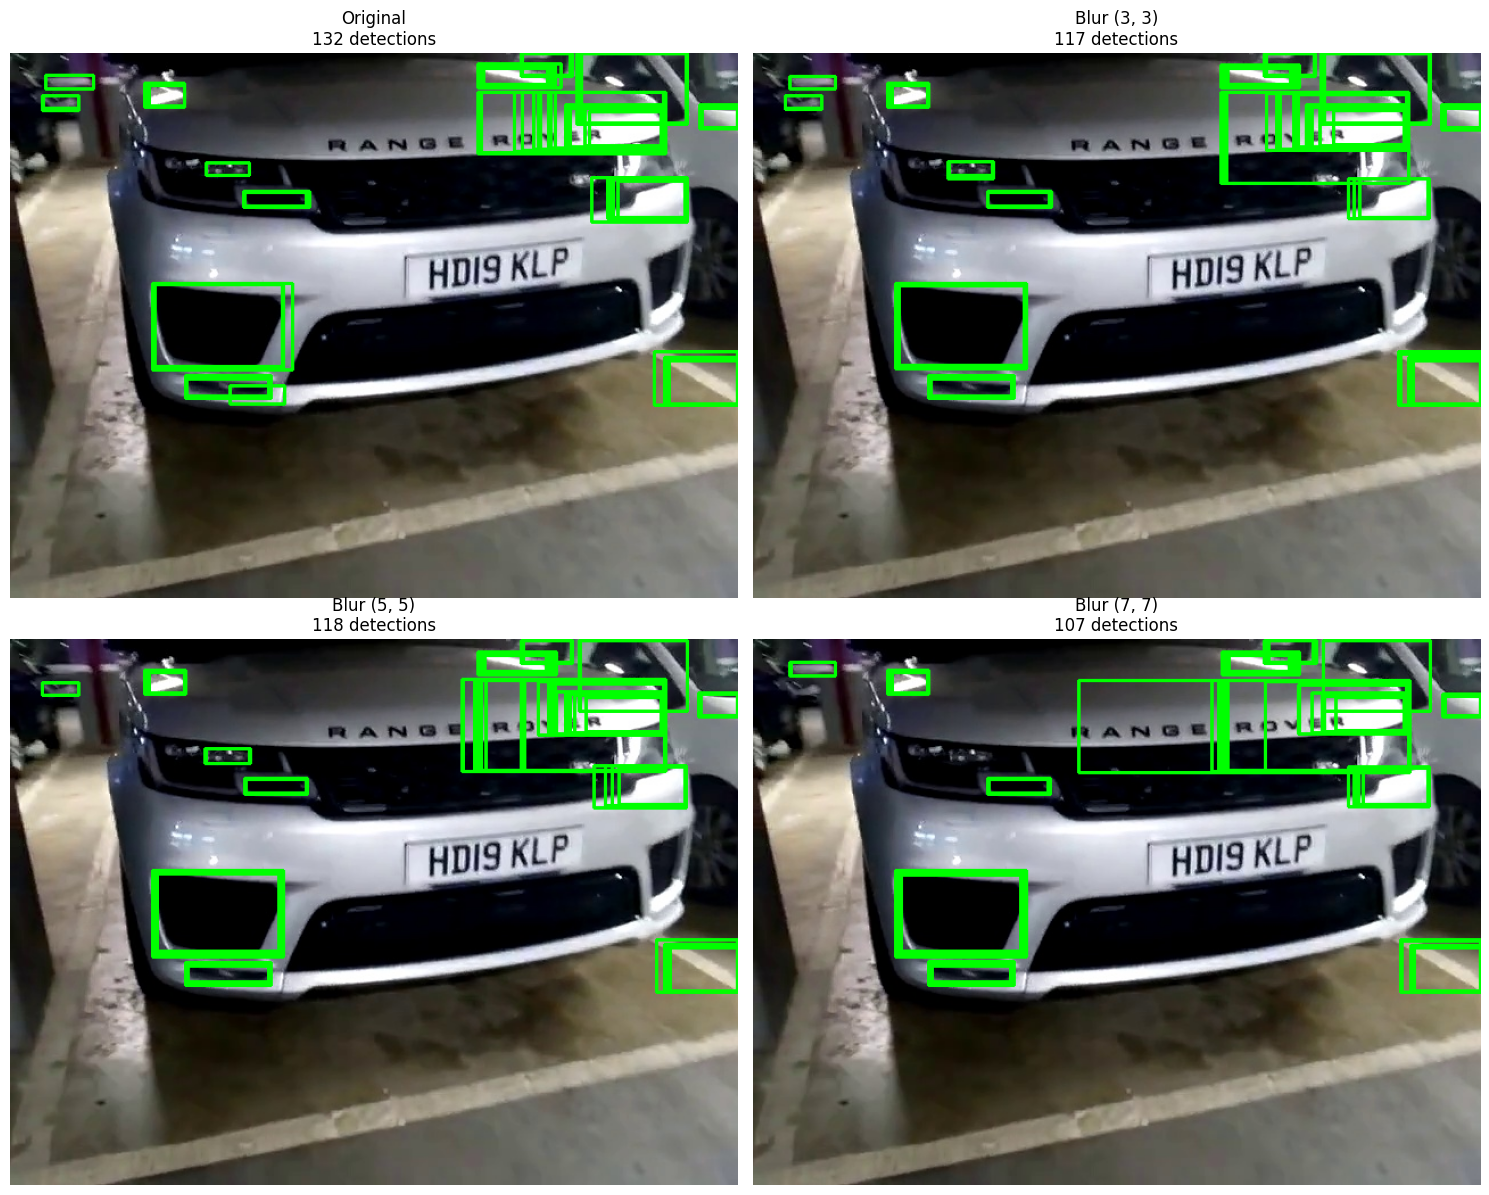


Best performing configuration: Original
Detected 132 potential license plates


In [17]:
# Function to detect and filter MSER regions
def detect_and_filter_mser(input_image, image_title="Image"):
    """Apply MSER detection and filtering to an input image"""
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(input_image)
    
    # Filter regions
    filtered_regions = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
        aspect_ratio = w / h if h > 0 else 0
        
        if (1.5 < aspect_ratio < 6.0 and 
            30 < w < 300 and 
            10 < h < 100):
            filtered_regions.append((x, y, w, h))
    
    return regions, filtered_regions

# Test MSER on original and blurred images
results = {}
test_images = {"Original": gray}
test_images.update({f"Blur {k}": v for k, v in blurred_images.items()})

print("MSER Detection Results Comparison:")
print("="*50)

for name, img in test_images.items():
    all_regions, filtered_regions = detect_and_filter_mser(img, name)
    results[name] = {
        'image': img,
        'all_regions': all_regions,
        'filtered_regions': filtered_regions,
        'total_regions': len(all_regions),
        'filtered_count': len(filtered_regions)
    }
    print(f"{name:12}: {len(all_regions):4} total regions → {len(filtered_regions):2} filtered")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, data) in enumerate(results.items()):
    if i < len(axes):
        # Create visualization image
        vis_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
        
        # Draw filtered regions
        for x, y, w, h in data['filtered_regions']:
            cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        axes[i].imshow(vis_image)
        axes[i].set_title(f"{name}\n{data['filtered_count']} detections")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Find the best performing configuration
best_name = max(results.keys(), key=lambda x: results[x]['filtered_count'])
print(f"\nBest performing configuration: {best_name}")
print(f"Detected {results[best_name]['filtered_count']} potential license plates")

## 2.3 Morphological Transformations

Morphological operations can significantly improve license plate detection by:
- **Closing**: Fills small gaps within text characters
- **Opening**: Removes small noise while preserving larger structures
- **Dilation**: Expands text regions to connect nearby characters
- **Erosion**: Shrinks regions to remove noise
- **Top Hat**: Enhances bright text on dark backgrounds
- **Black Hat**: Enhances dark text on bright backgrounds

Let's explore how these operations affect MSER detection.

Created 13 morphological variations
Operations: ['Original', 'Opening_rectangular_3x3', 'Closing_rectangular_3x3', 'TopHat_rectangular_3x3', 'BlackHat_rectangular_3x3', 'Opening_rectangular_5x3', 'Closing_rectangular_5x3', 'TopHat_rectangular_5x3', 'BlackHat_rectangular_5x3', 'Opening_elliptical_5x5'] ... (showing first 10)


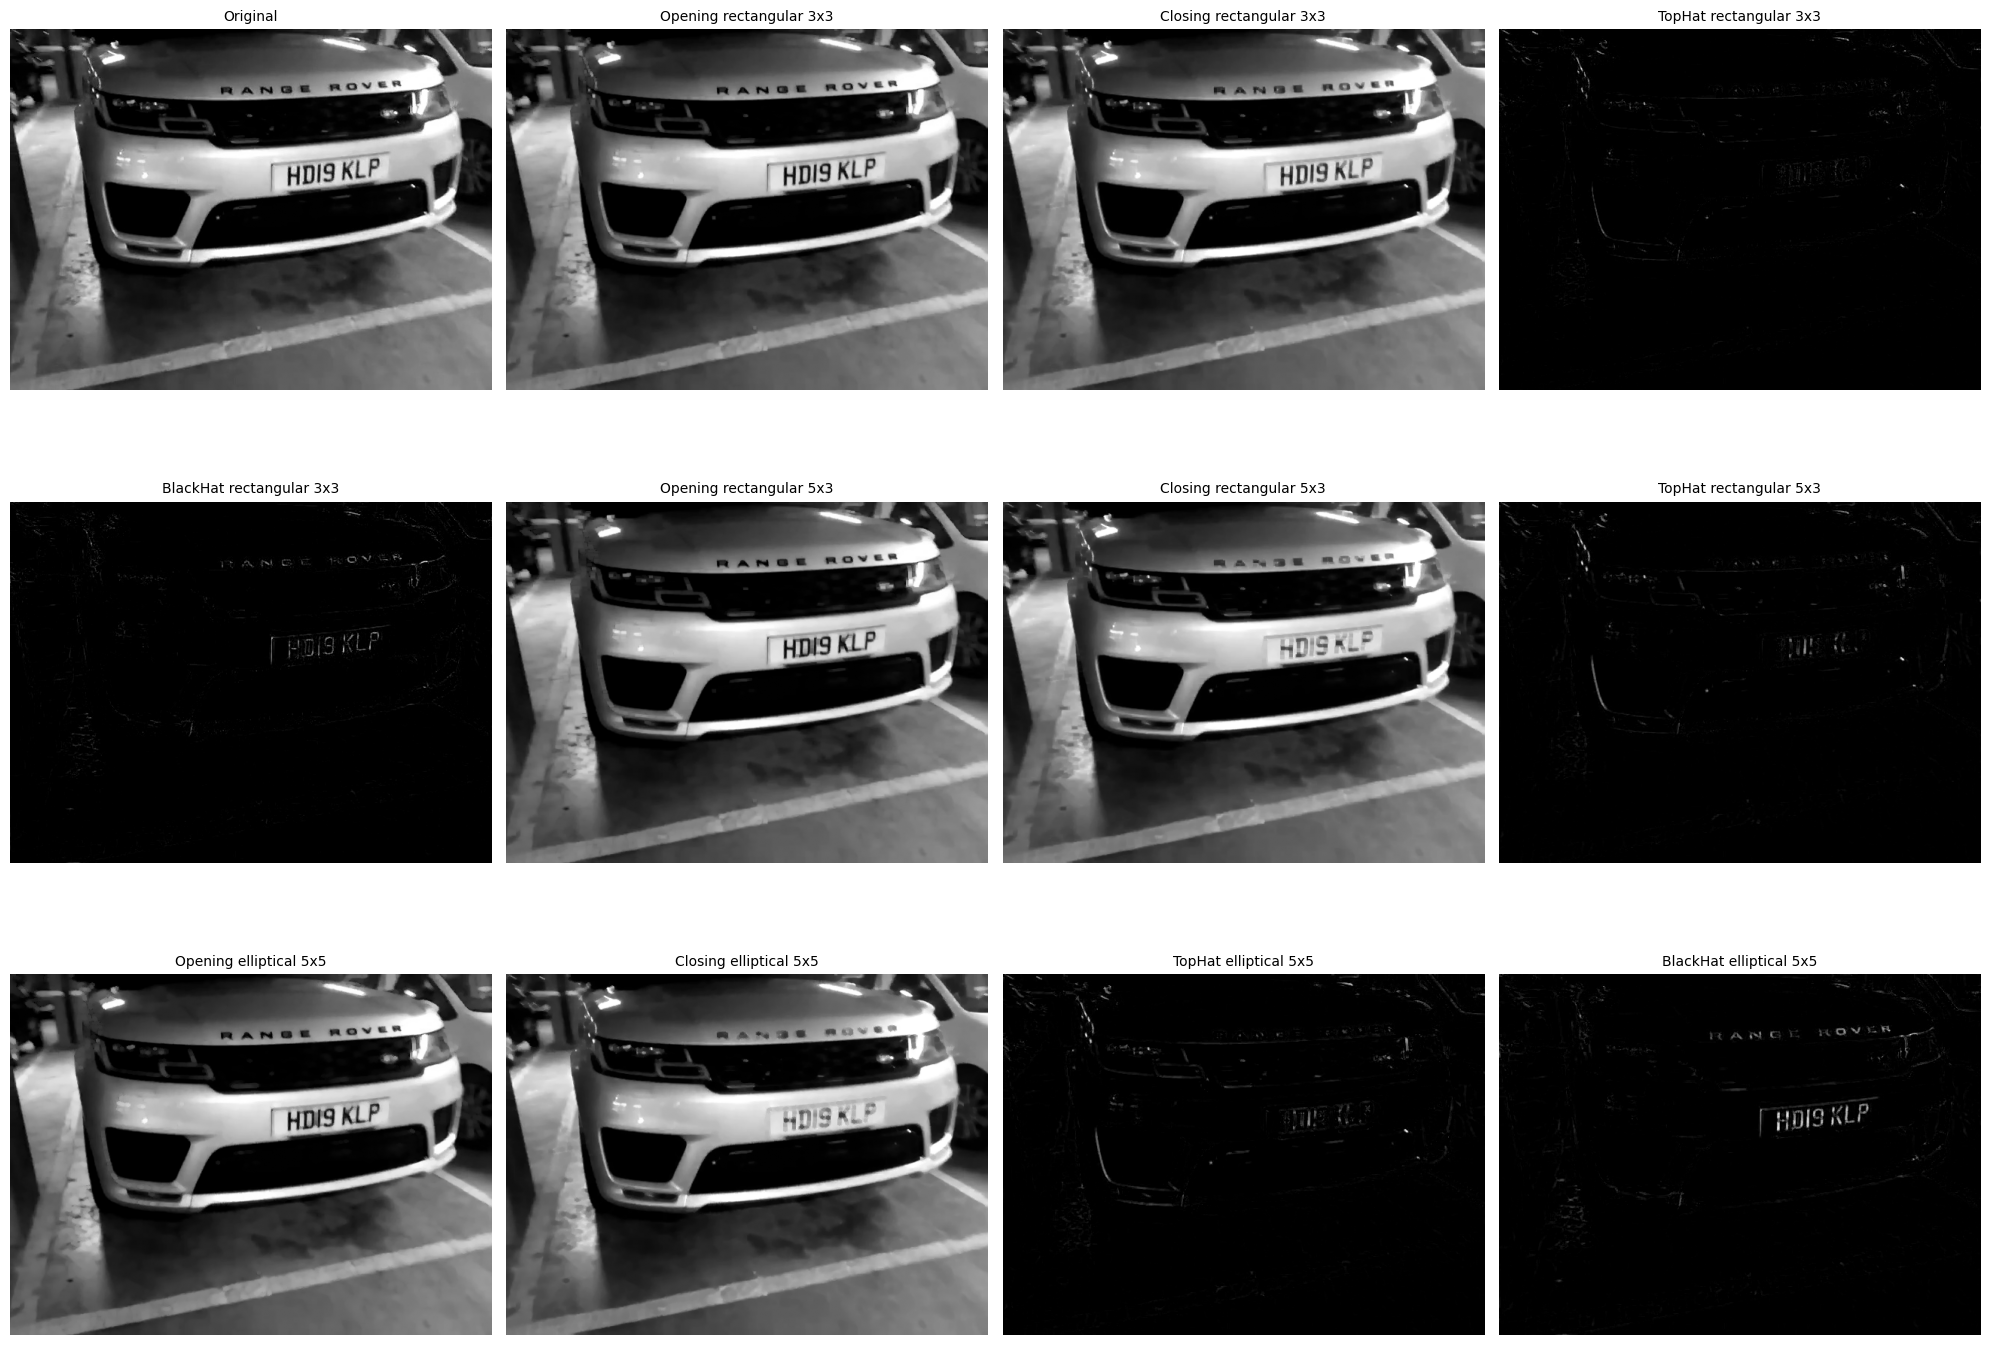

In [18]:
# Define different morphological operations and kernels
morphological_ops = {
    'Original': gray,
}

# Different kernel sizes and shapes
kernels = {
    'rectangular_3x3': cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
    'rectangular_5x3': cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3)),
    'elliptical_5x5': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)),
}

# Apply different morphological operations
for kernel_name, kernel in kernels.items():
    # Opening (erosion followed by dilation) - removes noise
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    morphological_ops[f'Opening_{kernel_name}'] = opening
    
    # Closing (dilation followed by erosion) - fills gaps
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    morphological_ops[f'Closing_{kernel_name}'] = closing
    
    # Top Hat (difference between source and opening) - enhances bright objects
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    morphological_ops[f'TopHat_{kernel_name}'] = tophat
    
    # Black Hat (difference between closing and source) - enhances dark objects
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    morphological_ops[f'BlackHat_{kernel_name}'] = blackhat

print(f"Created {len(morphological_ops)} morphological variations")
print("Operations:", list(morphological_ops.keys())[:10], "... (showing first 10)")

# Visualize a selection of morphological operations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Select representative operations to display
display_ops = [
    'Original',
    'Opening_rectangular_3x3',
    'Closing_rectangular_3x3', 
    'TopHat_rectangular_3x3',
    'BlackHat_rectangular_3x3',
    'Opening_rectangular_5x3',
    'Closing_rectangular_5x3',
    'TopHat_rectangular_5x3',
    'Opening_elliptical_5x5',
    'Closing_elliptical_5x5',
    'TopHat_elliptical_5x5',
    'BlackHat_elliptical_5x5'
]

for i, op_name in enumerate(display_ops):
    if i < len(axes) and op_name in morphological_ops:
        img = morphological_ops[op_name]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(op_name.replace('_', ' '), fontsize=10)
        axes[i].axis('off')

# Hide unused subplots
for j in range(len(display_ops), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 2.4 MSER Detection with Morphological Preprocessing

Now let's test how different morphological operations affect MSER detection performance.

MSER Detection Results with Morphological Operations:
Operation                 Total Regions   Filtered   Quality Score
----------------------------------------------------------------------
Original                  675             132        19.56%
Opening_rectangular_3x3   628             125        19.90%
Closing_rectangular_3x3   560             116        20.71%
TopHat_rectangular_3x3    1               0          0.00%
BlackHat_rectangular_3x3  4               0          0.00%
Opening_rectangular_5x3   576             137        23.78%
Closing_rectangular_5x3   465             112        24.09%
TopHat_rectangular_5x3    35              0          0.00%
BlackHat_rectangular_5x3  83              0          0.00%
Opening_elliptical_5x5    551             105        19.06%
Closing_elliptical_5x5    463             111        23.97%
TopHat_elliptical_5x5     34              0          0.00%
BlackHat_elliptical_5x5   96              0          0.00%

Top 6 performing operations:
1. O

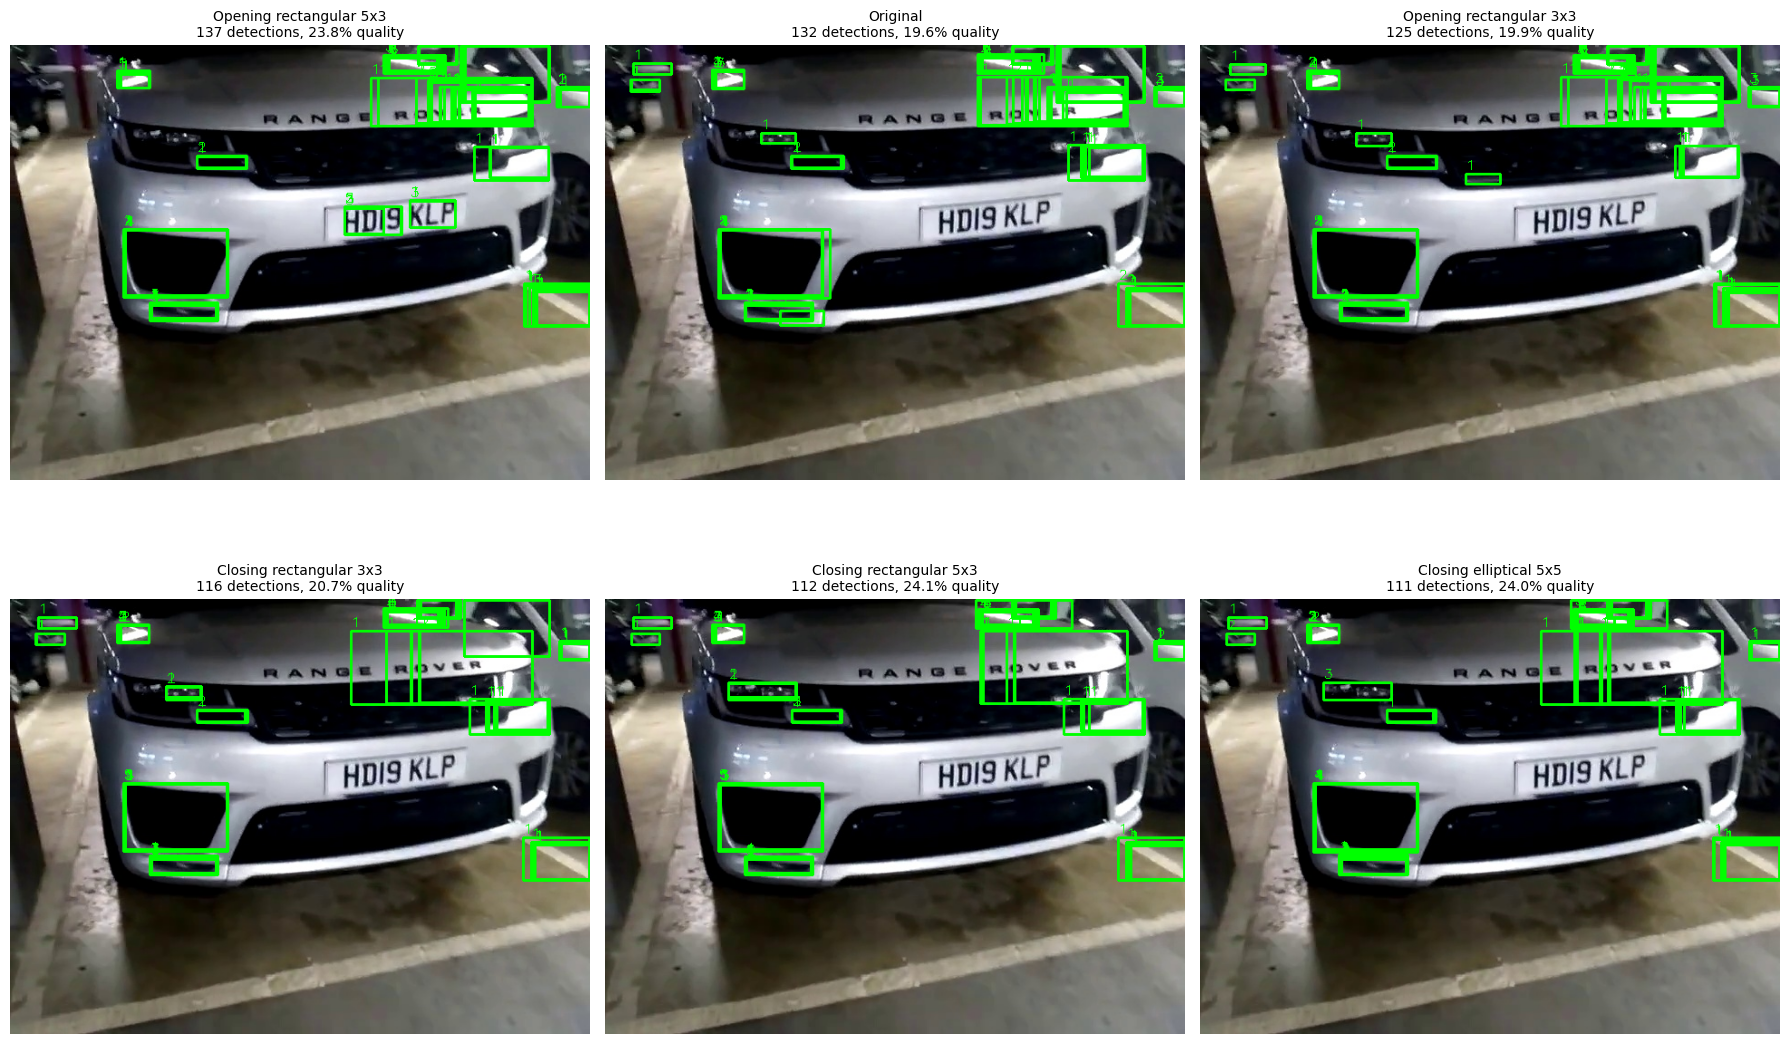


🏆 Best morphological operation: Opening_rectangular_5x3
   - Detected regions: 137
   - Quality score: 23.78%
   - Total regions processed: 576


In [19]:
# Test MSER on all morphological variations
morph_results = {}

print("MSER Detection Results with Morphological Operations:")
print("="*70)
print(f"{'Operation':<25} {'Total Regions':<15} {'Filtered':<10} {'Quality Score'}")
print("-"*70)

for name, morph_image in morphological_ops.items():
    all_regions, filtered_regions = detect_and_filter_mser(morph_image, name)
    
    # Calculate quality score (filtered regions / total regions ratio)
    quality_score = len(filtered_regions) / max(len(all_regions), 1) * 100
    
    morph_results[name] = {
        'image': morph_image,
        'all_regions': all_regions,
        'filtered_regions': filtered_regions,
        'total_regions': len(all_regions),
        'filtered_count': len(filtered_regions),
        'quality_score': quality_score
    }
    
    print(f"{name:<25} {len(all_regions):<15} {len(filtered_regions):<10} {quality_score:.2f}%")

# Find top performing operations
top_operations = sorted(morph_results.items(), 
                       key=lambda x: (x[1]['filtered_count'], -x[1]['total_regions']), 
                       reverse=True)[:6]

print(f"\nTop {len(top_operations)} performing operations:")
for i, (name, data) in enumerate(top_operations, 1):
    print(f"{i}. {name}: {data['filtered_count']} detections, {data['quality_score']:.2f}% quality")

# Visualize top performing operations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, data) in enumerate(top_operations):
    if i < len(axes):
        # Create visualization
        vis_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
        
        # Draw detected regions
        for x, y, w, h in data['filtered_regions']:
            cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Add region number
            cv2.putText(vis_image, str(len([r for r in data['filtered_regions'] if r == (x, y, w, h)])), 
                       (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        axes[i].imshow(vis_image)
        axes[i].set_title(f"{name.replace('_', ' ')}\n{data['filtered_count']} detections, {data['quality_score']:.1f}% quality", 
                         fontsize=10)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Best operation summary
best_morph = top_operations[0][0]
print(f"\n🏆 Best morphological operation: {best_morph}")
print(f"   - Detected regions: {morph_results[best_morph]['filtered_count']}")
print(f"   - Quality score: {morph_results[best_morph]['quality_score']:.2f}%")
print(f"   - Total regions processed: {morph_results[best_morph]['total_regions']}")

## 2.5 Combined Preprocessing: Gaussian Blur + Morphological Operations

Let's combine the best Gaussian blur configuration with the top morphological operations to see if we can achieve even better results.

Best blur configuration: Original
Top morphological operations: ['Opening_rectangular_5x3', 'Original', 'Opening_rectangular_3x3']

Testing combined preprocessing approaches:
Original + Opening_rectangular_5x3       137        23.78%
Original + Opening_rectangular_3x3       125        19.90%

🔍 Final Comparison:
--------------------------------------------------
Original: 132 detections
Best Blur (Original): 132 detections
Best Morph (Opening_rectangular_5x3): 137 detections
Best Combined (Original + Opening_rectangular_5x3): 137 detections


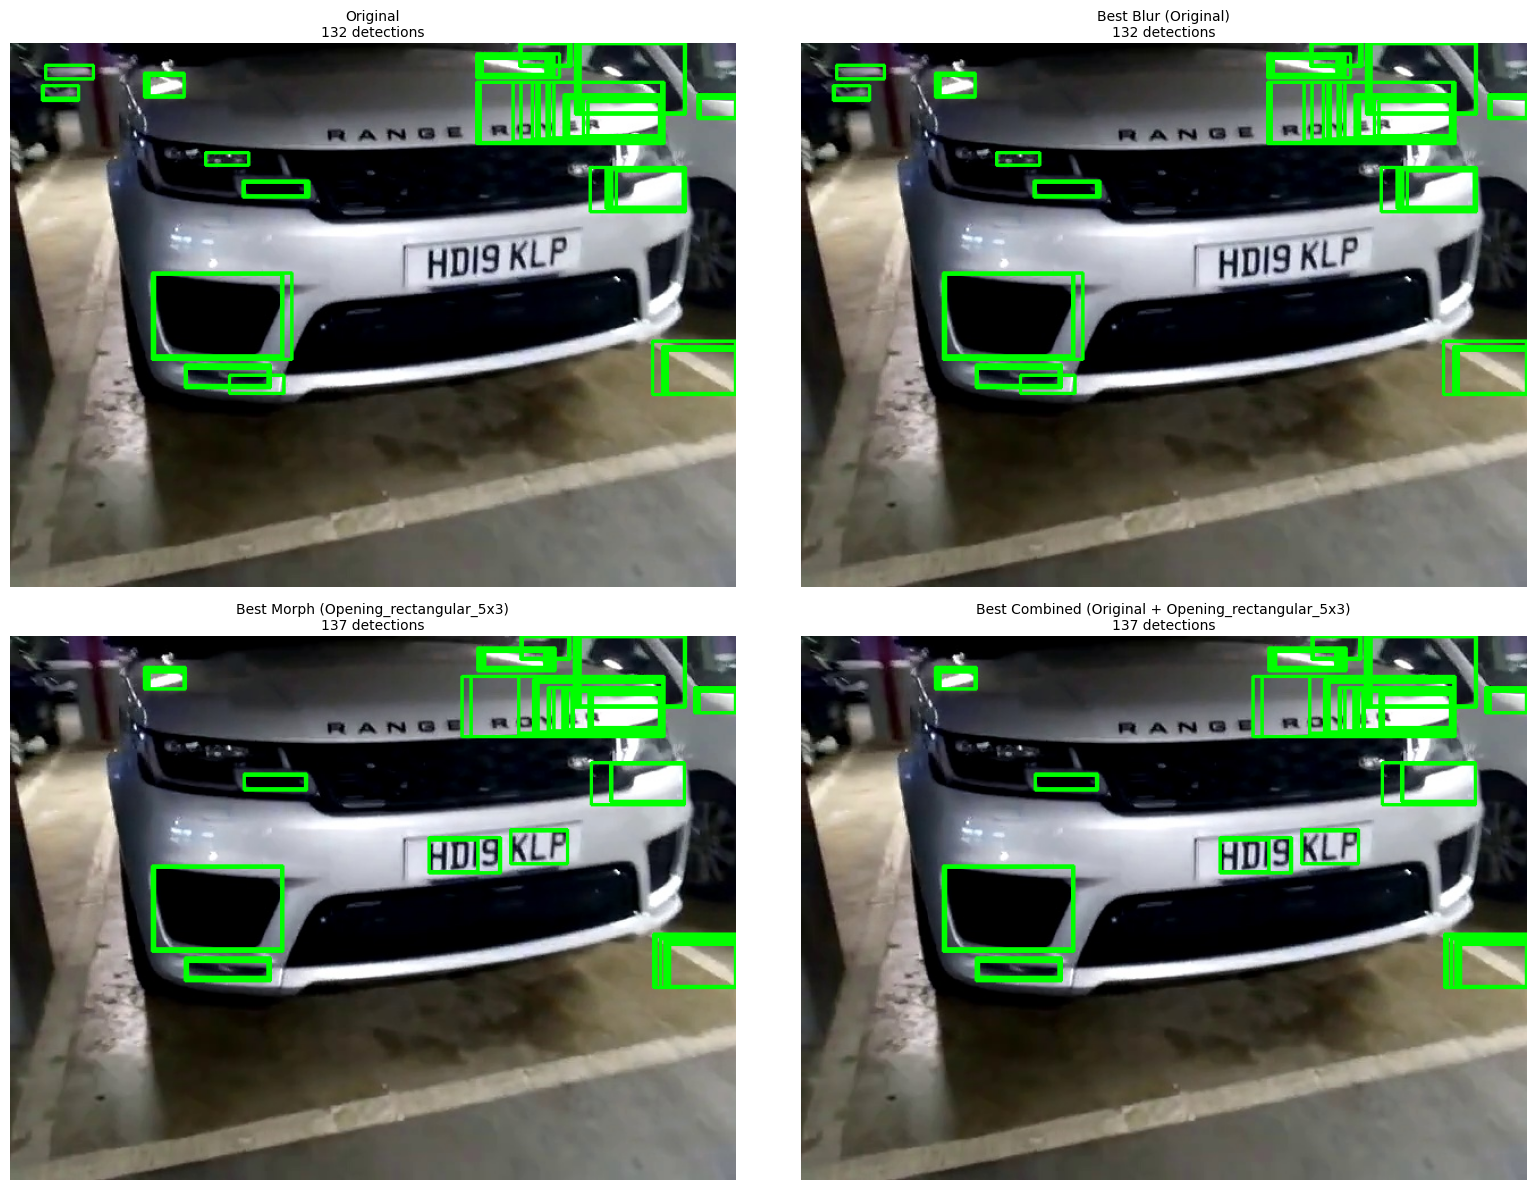


🎯 ULTIMATE BEST CONFIGURATION:
   Method: Opening_rectangular_5x3
   Detections: 137
   Quality Score: 23.78%


In [20]:
# Get the best blur and morphological configurations from previous results
best_blur = max(results.keys(), key=lambda x: results[x]['filtered_count'])
best_morph_ops = [name for name, _ in top_operations[:3]]  # Top 3 morphological operations

print(f"Best blur configuration: {best_blur}")
print(f"Top morphological operations: {best_morph_ops}")

# Create combined preprocessing pipelines
combined_results = {}
kernels_dict = {
    'rectangular_3x3': cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
    'rectangular_5x3': cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3)),
    'elliptical_5x5': cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)),
}

# Get the best blur image
if 'Blur' in best_blur:
    kernel_size = eval(best_blur.split('(')[1].split(')')[0])
    best_blur_image = cv2.GaussianBlur(gray, kernel_size, 0)
else:
    best_blur_image = gray

print(f"\nTesting combined preprocessing approaches:")
print("="*60)

# Test combinations
for morph_name in best_morph_ops[:3]:  # Test top 3
    if morph_name == 'Original':
        continue
        
    # Extract operation and kernel info
    parts = morph_name.split('_')
    operation = parts[0]
    kernel_name = '_'.join(parts[1:])
    
    if kernel_name in kernels_dict:
        kernel = kernels_dict[kernel_name]
        
        # Apply morphological operation to the best blur image
        if operation == 'Opening':
            combined_image = cv2.morphologyEx(best_blur_image, cv2.MORPH_OPEN, kernel)
        elif operation == 'Closing':
            combined_image = cv2.morphologyEx(best_blur_image, cv2.MORPH_CLOSE, kernel)
        elif operation == 'TopHat':
            combined_image = cv2.morphologyEx(best_blur_image, cv2.MORPH_TOPHAT, kernel)
        elif operation == 'BlackHat':
            combined_image = cv2.morphologyEx(best_blur_image, cv2.MORPH_BLACKHAT, kernel)
        else:
            continue
            
        # Test MSER detection
        all_regions, filtered_regions = detect_and_filter_mser(combined_image)
        quality_score = len(filtered_regions) / max(len(all_regions), 1) * 100
        
        combined_name = f"{best_blur} + {morph_name}"
        combined_results[combined_name] = {
            'image': combined_image,
            'filtered_regions': filtered_regions,
            'filtered_count': len(filtered_regions),
            'quality_score': quality_score,
            'total_regions': len(all_regions)
        }
        
        print(f"{combined_name:<40} {len(filtered_regions):<10} {quality_score:.2f}%")

# Compare all approaches: Original, Best Blur, Best Morph, Best Combined
comparison_data = {
    'Original': results['Original'],
    f'Best Blur ({best_blur})': results[best_blur],
    f'Best Morph ({best_morph})': morph_results[best_morph]
}

if combined_results:
    best_combined = max(combined_results.items(), key=lambda x: x[1]['filtered_count'])
    comparison_data[f'Best Combined ({best_combined[0]})'] = best_combined[1]

# Final comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

print(f"\n🔍 Final Comparison:")
print("-" * 50)

for i, (name, data) in enumerate(comparison_data.items()):
    if i < len(axes):
        # Create visualization
        vis_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
        
        # Draw detected regions
        for x, y, w, h in data['filtered_regions']:
            cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        axes[i].imshow(vis_image)
        axes[i].set_title(f"{name}\n{data['filtered_count']} detections", fontsize=10, wrap=True)
        axes[i].axis('off')
        
        print(f"{name}: {data['filtered_count']} detections")

# Hide unused subplots
for j in range(len(comparison_data), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Final recommendation
all_results = {**results, **morph_results, **combined_results}
ultimate_best = max(all_results.items(), key=lambda x: x[1]['filtered_count'])

print(f"\n🎯 ULTIMATE BEST CONFIGURATION:")
print(f"   Method: {ultimate_best[0]}")
print(f"   Detections: {ultimate_best[1]['filtered_count']}")
print(f"   Quality Score: {ultimate_best[1]['quality_score']:.2f}%")

## 3. Initialize MSER Detector

Create an MSER detector object with default parameters. MSER detects stable regions in the image that remain unchanged under intensity transformations.

In [21]:
# Initialize MSER detector
mser = cv2.MSER_create()
print("MSER detector initialized successfully")

# Optional: Display MSER parameters
print("\nMSER Parameters:")
print(f"Delta: {mser.getDelta()}")
print(f"Min Area: {mser.getMinArea()}")
print(f"Max Area: {mser.getMaxArea()}")

MSER detector initialized successfully

MSER Parameters:
Delta: 5
Min Area: 60
Max Area: 14400


## 4. Detect MSER Regions

Use the MSER detector to find regions in the grayscale image and visualize all detected regions.

Total MSER regions detected: 675


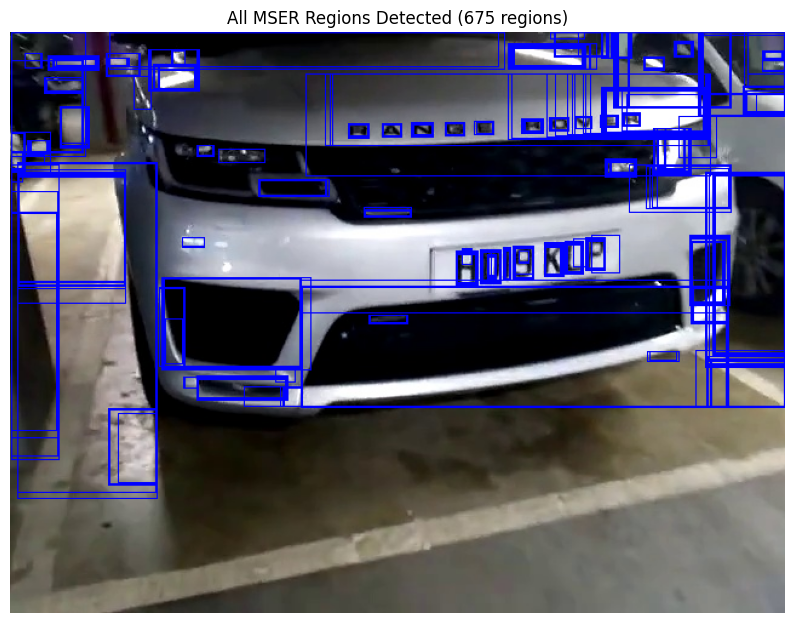

In [22]:
# Detect MSER regions
regions, _ = mser.detectRegions(gray)
print(f"Total MSER regions detected: {len(regions)}")

# Create a visualization of all MSER regions
all_regions_image = image.copy()
for i, region in enumerate(regions):
    # Get bounding rectangle for each region
    x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
    # Draw all regions in blue
    cv2.rectangle(all_regions_image, (x, y), (x + w, y + h), (255, 0, 0), 1)

# Display all detected regions
plt.figure(figsize=(10, 8))
all_regions_rgb = cv2.cvtColor(all_regions_image, cv2.COLOR_BGR2RGB)
plt.imshow(all_regions_rgb)
plt.title(f'All MSER Regions Detected ({len(regions)} regions)')
plt.axis('off')
plt.show()

## 5. Filter Regions by Aspect Ratio and Size

Filter detected regions based on aspect ratio (1.5-6.0) and size constraints to identify potential license plates. License plates typically have specific dimensional characteristics.

In [23]:
# Filter regions based on license plate characteristics
filtered_regions = []
filtered_info = []

for region in regions:
    x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
    aspect_ratio = w / h if h > 0 else 0
    area = w * h
    
    # License plate filtering criteria
    if (1.5 < aspect_ratio < 6.0 and 
        30 < w < 300 and 
        10 < h < 100):
        filtered_regions.append((x, y, w, h))
        filtered_info.append({
            'bbox': (x, y, w, h),
            'aspect_ratio': aspect_ratio,
            'area': area
        })

print(f"Regions after filtering: {len(filtered_regions)}")
print("\nFiltered region details:")
for i, info in enumerate(filtered_info):
    print(f"Region {i+1}: bbox={info['bbox']}, aspect_ratio={info['aspect_ratio']:.2f}, area={info['area']}")

Regions after filtering: 132

Filtered region details:
Region 1: bbox=(206, 123, 54, 12), aspect_ratio=4.50, area=648
Region 2: bbox=(206, 122, 55, 13), aspect_ratio=4.23, area=715
Region 3: bbox=(206, 122, 55, 14), aspect_ratio=3.93, area=770
Region 4: bbox=(206, 122, 55, 14), aspect_ratio=3.93, area=770
Region 5: bbox=(205, 122, 56, 14), aspect_ratio=4.00, area=784
Region 6: bbox=(205, 122, 58, 14), aspect_ratio=4.14, area=812
Region 7: bbox=(127, 204, 112, 72), aspect_ratio=1.56, area=8064
Region 8: bbox=(127, 204, 112, 73), aspect_ratio=1.53, area=8176
Region 9: bbox=(127, 204, 112, 73), aspect_ratio=1.53, area=8176
Region 10: bbox=(127, 204, 112, 73), aspect_ratio=1.53, area=8176
Region 11: bbox=(127, 204, 112, 73), aspect_ratio=1.53, area=8176
Region 12: bbox=(126, 204, 113, 73), aspect_ratio=1.55, area=8249
Region 13: bbox=(126, 204, 114, 73), aspect_ratio=1.56, area=8322
Region 14: bbox=(126, 204, 114, 73), aspect_ratio=1.56, area=8322
Region 15: bbox=(126, 204, 114, 73), aspec

## 6. Draw Bounding Rectangles

Draw green bounding rectangles around filtered regions that match license plate characteristics.

In [24]:
# Create a copy of the original image for drawing results
result_image = image.copy()

# Draw bounding rectangles for filtered regions
for x, y, w, h in filtered_regions:
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Add region number as label
    cv2.putText(result_image, f'Plate?', (x, y-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Drew {len(filtered_regions)} potential license plate regions")

Drew 132 potential license plate regions


## 7. Display Results

Display the original image with detected license plate regions highlighted, along with a comparison view.

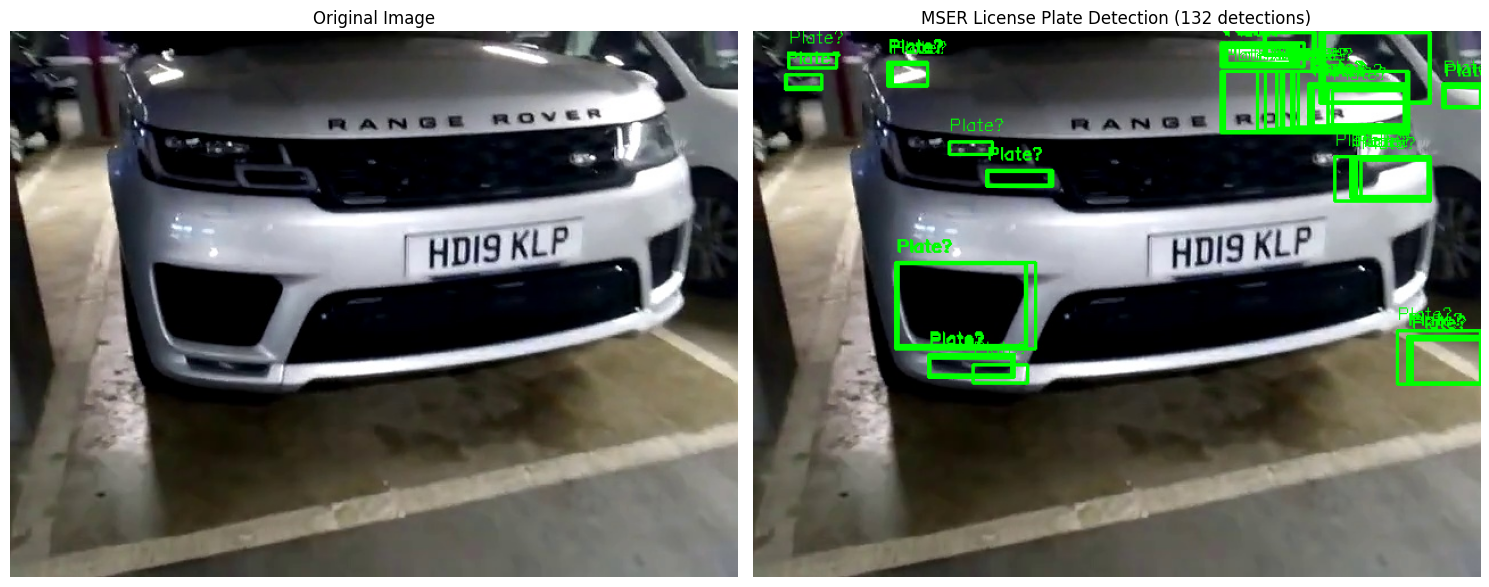


=== Detection Summary ===
Total MSER regions found: 675
Regions after filtering: 132
Filter criteria:
  - Aspect ratio: 1.5 to 6.0
  - Width: 30 to 300 pixels
  - Height: 10 to 100 pixels


In [25]:
# Display the final result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Original image
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(original_rgb)
ax1.set_title('Original Image')
ax1.axis('off')

# Result with detections
result_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
ax2.imshow(result_rgb)
ax2.set_title(f'MSER License Plate Detection ({len(filtered_regions)} detections)')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Detection Summary ===")
print(f"Total MSER regions found: {len(regions)}")
print(f"Regions after filtering: {len(filtered_regions)}")
print(f"Filter criteria:")
print(f"  - Aspect ratio: 1.5 to 6.0")
print(f"  - Width: 30 to 300 pixels")
print(f"  - Height: 10 to 100 pixels")

## 8. Test with Different Images (Optional)

You can test the detection algorithm with other images in the sample_images folder.

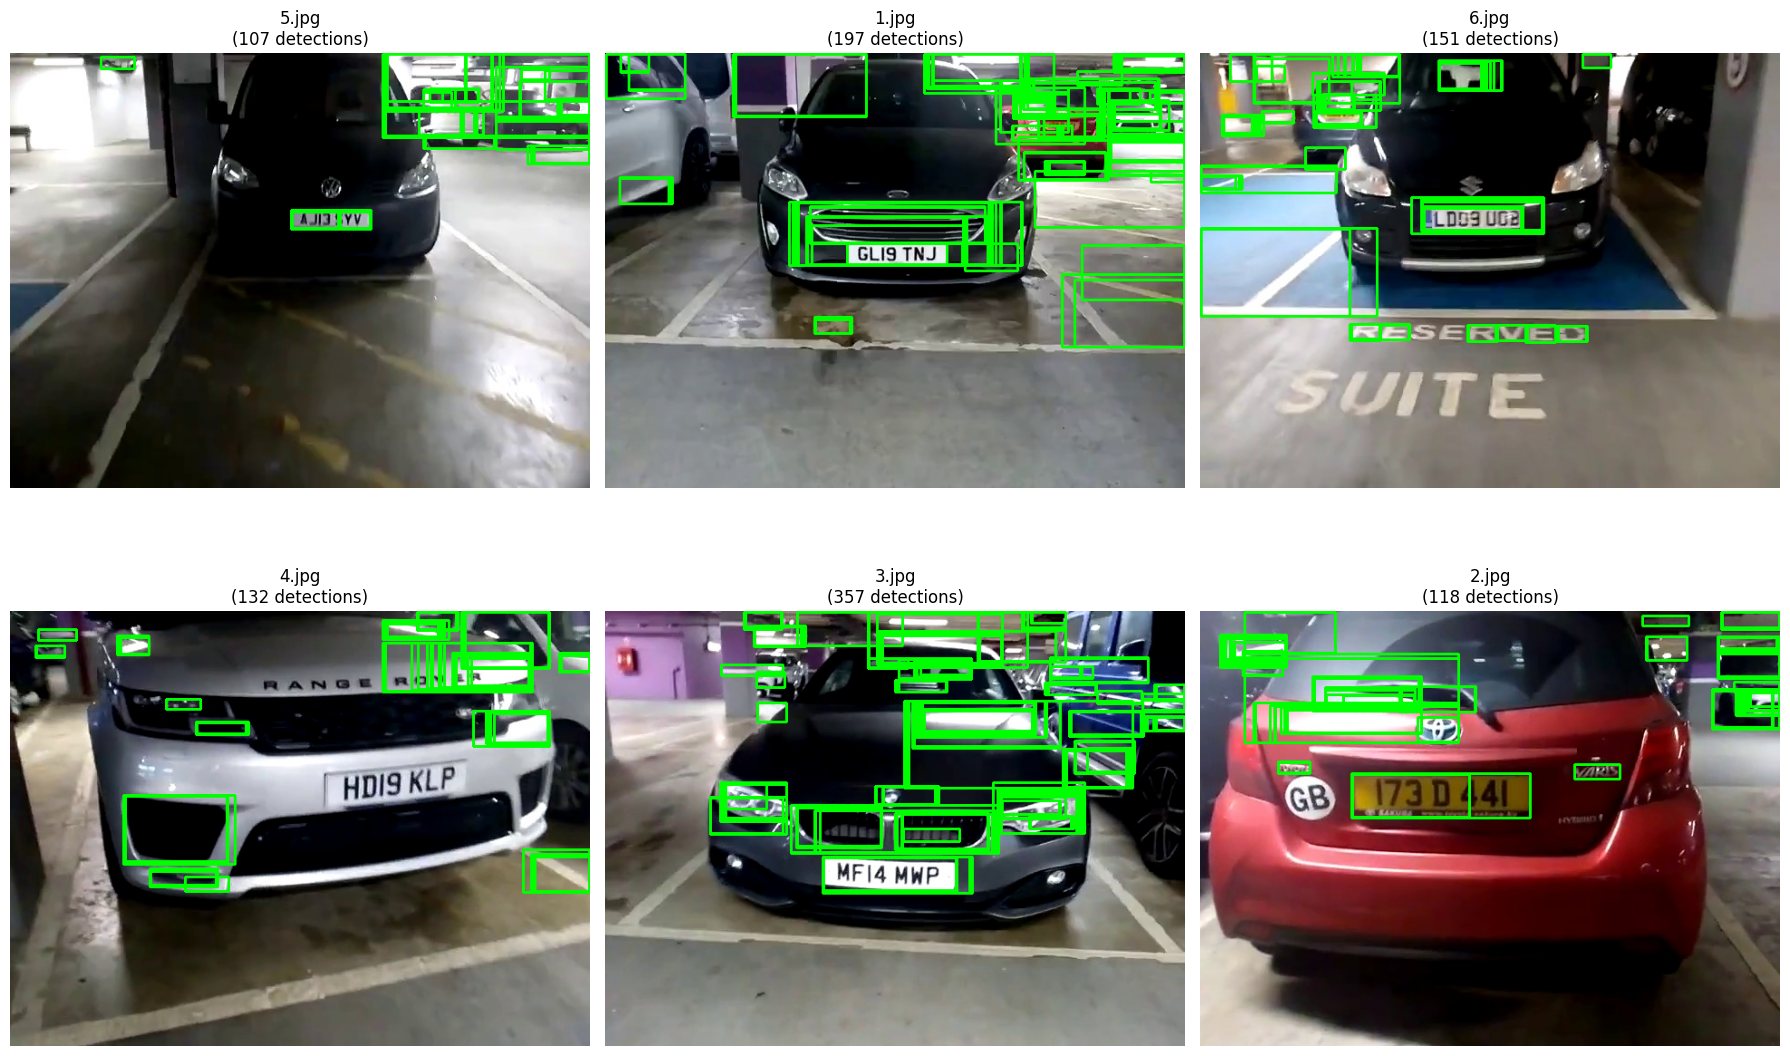

In [26]:
# Function to process multiple images
def detect_license_plates(image_path):
    """Process a single image and return detection results"""
    img = cv2.imread(image_path)
    if img is None:
        return None, 0
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray)
    
    filtered_count = 0
    result_img = img.copy()
    
    for region in regions:
        x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
        aspect_ratio = w / h if h > 0 else 0
        
        if (1.5 < aspect_ratio < 6.0 and 
            30 < w < 300 and 
            10 < h < 100):
            cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            filtered_count += 1
    
    return result_img, filtered_count

# Test with multiple images
import os
sample_dir = "./sample_images"
if os.path.exists(sample_dir):
    image_files = [f for f in os.listdir(sample_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, img_file in enumerate(image_files[:6]):  # Process up to 6 images
        img_path = os.path.join(sample_dir, img_file)
        result, count = detect_license_plates(img_path)
        
        if result is not None and i < len(axes):
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
            axes[i].imshow(result_rgb)
            axes[i].set_title(f'{img_file}\n({count} detections)')
            axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(len(image_files), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Sample images directory not found.")